In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io

import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def decode(x):
    d = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
    return d[x]

cpu


In [205]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

model_cell = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

In [206]:
model_cell

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [207]:
model_cell.classifier[3] = nn.Linear(1024, 4)
model_cell

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [208]:
for param in model_cell.parameters():
    param.requires_grad = False

model_cell.classifier[3].weight.requires_grad = True
model_cell.classifier[3].bias.requires_grad = True

model_cell.to(device);

In [209]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    'data/train/images/TRAIN',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    'data/train/images/TEST',
    transform=trnsfrms
)

In [210]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [211]:
optimizer = torch.optim.Adam(model_cell.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

In [212]:
img, label = next(iter(train_loader))

In [213]:
true = label[0].item()

img = img[0]

true, img.shape

(1, torch.Size([3, 224, 224]))

In [214]:
model_cell.eval();

In [215]:
idx2class= {j: i for i, j in valid_dataset.class_to_idx.items()}
idx2class

{0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

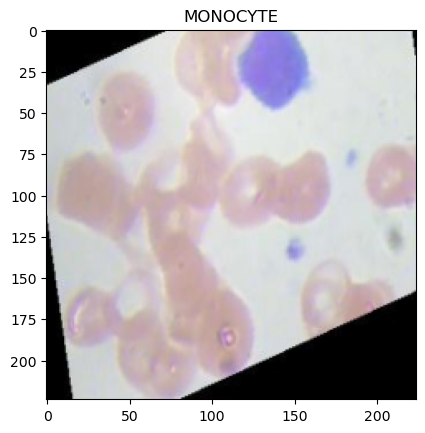

In [216]:
with torch.inference_mode():
    pred_class = model_cell(img.unsqueeze(0).to(device)).argmax(dim=1).item()
plt.title(idx2class[pred_class]);
plt.imshow(img.permute(1,2,0));

In [217]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(5):
    model_cell.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_cell(images)#.squeeze(-1)

        loss = criterion(preds, labels.long())

        loss_batch.append(loss.item())

        accuracy = (preds.argmax(dim=1).round() == labels).cpu().numpy().mean()

        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model_cell.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model_cell(images).squeeze(-1)

        loss = criterion(preds, labels.long())
        loss_batch.append(loss.item())

        accuracy = (preds.argmax(dim=1).round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t   metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

Epoch: 0  loss_train: 0.655, loss_valid: 1.512
	   metrics_train: 0.749, metrics_valid: 0.423
Epoch: 1  loss_train: 0.457, loss_valid: 1.348
	   metrics_train: 0.828, metrics_valid: 0.538
Epoch: 2  loss_train: 0.418, loss_valid: 1.244
	   metrics_train: 0.837, metrics_valid: 0.560
Epoch: 3  loss_train: 0.410, loss_valid: 1.129
	   metrics_train: 0.839, metrics_valid: 0.606
Epoch: 4  loss_train: 0.392, loss_valid: 1.247
	   metrics_train: 0.845, metrics_valid: 0.590


In [218]:
torch.save(model_cell.state_dict(), 'weights_cell_2.pt')